# Stock Market chart pattern recognition using deep learning 

Phase 1: Business Understanding
ในขั้นนี้เราต้องกำหนดวัตถุประสงค์ให้ชัดเจน เนื่องจากโค้ดของคุณมีการใช้ทั้ง CNN/LSTM (มักใช้ทำ Price Prediction) และ Transformers (มักใช้ทำ Sentiment Analysis จากข่าวหุ้น)

Objective: วิเคราะห์และพยากรณ์แนวโน้มราคาหุ้น โดยใช้ข้อมูลราคา (Numeric) ร่วมกับปัจจัยด้านอารมณ์ตลาด (Sentiment)

Success Metrics:

Price Model: ตรวจวัดด้วย MAE, RMSE

Sentiment Model: ตรวจวัดด้วย Accuracy, F1-Score

Cell 1: Import Libraries

Cell 2: System Configuration & Class Setup

In [2]:
# Cassandra
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler

class StockAnalysisSystem:
    def __init__(self, cassandra_host='127.0.0.1', cassandra_port=9042):
        self.cassandra_host = cassandra_host
        self.cassandra_port = cassandra_port
        self.scaler = MinMaxScaler()

# ตั้งค่า Parameter เบื้องต้น
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'BTC' # หรือระบุชื่อหุ้นที่ต้องการ

print(f"System initialized for symbol: {SYMBOL}")

System initialized for symbol: BTC


Phase 2: Data Understanding

Cell 3: Data Acquisition Function

In [3]:
import numpy as np
import pandas as pd

def get_candlestick_data(symbol, cassandra_host, cassandra_port, limit=1000):
    cluster = Cluster([cassandra_host], port=cassandra_port)
    session = cluster.connect('data_stock')
    
    query = """
        SELECT symbol, time, open, high, low, close, volume, value 
        FROM candlestick_data 
        WHERE symbol = %s 
        LIMIT %s 
        ALLOW FILTERING
    """
    
    rows = session.execute(query, (symbol, limit))
    df = pd.DataFrame(list(rows))
    
    # แปลงเวลาและจัดเรียงข้อมูล
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    cluster.shutdown()
    return df

print("Function get_candlestick_data is ready.")

Function get_candlestick_data is ready.


Cell 4: Data Exploration (EDA)

In [4]:
# ดึงข้อมูลมาเก็บในตัวแปร df
df = get_candlestick_data(SYMBOL, CASSANDRA_HOST, CASSANDRA_PORT)

# ตรวจสอบโครงสร้างข้อมูล
print("--- Data Info ---")
print(df.info())

print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- First 5 Rows ---")
display(df.head())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  729 non-null    object        
 1   time    729 non-null    datetime64[ns]
 2   open    729 non-null    float64       
 3   high    729 non-null    float64       
 4   low     729 non-null    float64       
 5   close   729 non-null    float64       
 6   volume  729 non-null    int64         
 7   value   729 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 45.7+ KB
None

--- Descriptive Statistics ---


,time,open,high,low,close,volume,value
count,729,729.000000,729.000000,729.000000,729.000000,7.290000e+02,729.0
mean,2024-07-08 00:15:48.148148224,0.449863,0.460782,0.439328,0.448176,2.701844e+07,0.0
min,2023-01-10 00:00:00,0.260000,0.270000,0.260000,0.260000,3.935720e+05,0.0
25%,2023-10-06 00:00:00,0.370000,0.380000,0.360000,0.370000,5.324461e+06,0.0
50%,2024-07-09 00:00:00,0.440000,0.450000,0.430000,0.440000,1.104676e+07,0.0
75%,2025-04-03 00:00:00,0.520000,0.530000,0.510000,0.510000,2.754234e+07,0.0
max,2026-01-09 00:00:00,0.720000,0.740000,0.700000,0.720000,5.167988e+08,0.0
std,NaN,0.098850,0.101409,0.096382,0.098570,4.924019e+07,0.0



--- First 5 Rows ---


,symbol,time,open,high,low,close,volume,value
0,BTC,2023-01-10,0.43,0.44,0.42,0.43,8859470,0.0
1,BTC,2023-01-11,0.43,0.46,0.43,0.46,50122138,0.0
2,BTC,2023-01-12,0.46,0.51,0.46,0.48,151660107,0.0
3,BTC,2023-01-13,0.48,0.50,0.47,0.47,27542339,0.0
4,BTC,2023-01-16,0.51,0.52,0.49,0.49,67999004,0.0


Cell 5: Define Pattern Labeling Logic

In [5]:
def generate_hs_labels(df, window=5):
    """
    หา Head & Shoulders pattern พร้อมรายละเอียด
    - window: จำนวนแท่งเทียนรอบข้างที่ใช้ยืนยันจุด Peak
    """
    close_prices = df['close'].values
    labels = np.zeros(len(close_prices))
    
    # 1. หา local peaks (จุดสูงสุดในระยะ window)
    local_max_idx = []
    for i in range(window, len(close_prices) - window):
        is_peak = True
        for j in range(1, window + 1):
            if close_prices[i] <= close_prices[i-j] or close_prices[i] <= close_prices[i+j]:
                is_peak = False
                break
        if is_peak:
            local_max_idx.append(i)
    
    hs_patterns = []
    
    # 2. ตรวจสอบเงื่อนไข H&S pattern (3 peaks ต่อเนื่องกัน โดยอันกลางสูงที่สุด)
    for i in range(len(local_max_idx) - 2):
        ls_idx = local_max_idx[i]
        head_idx = local_max_idx[i + 1]
        rs_idx = local_max_idx[i + 2]
        
        ls_price = close_prices[ls_idx]
        head_price = close_prices[head_idx]
        rs_price = close_prices[rs_idx]
        
        # เงื่อนไข: Head สูงกว่าไหล่ทั้งสองข้าง และไหล่สองข้างมีราคาใกล้เคียงกัน (diff < 8%)
        if (head_price > ls_price and 
            head_price > rs_price and 
            ls_price > 0 and
            abs(ls_price - rs_price) / ls_price < 0.08):
            
            labels[ls_idx:rs_idx+1] = 1 # กำหนด Label เป็น 1 ในช่วงที่เกิด Pattern
            
            # หาจุดต่ำสุดระหว่างยอด (Neckline/Valleys)
            left_valley_idx = ls_idx + np.argmin(close_prices[ls_idx:head_idx+1])
            left_valley_price = close_prices[left_valley_idx]
            
            right_valley_idx = head_idx + np.argmin(close_prices[head_idx:rs_idx+1])
            right_valley_price = close_prices[right_valley_idx]
            
            hs_patterns.append({
                'left_shoulder': {'idx': ls_idx, 'price': ls_price},
                'head': {'idx': head_idx, 'price': head_price},
                'right_shoulder': {'idx': rs_idx, 'price': rs_price},
                'left_valley': {'idx': left_valley_idx, 'price': left_valley_price},
                'right_valley': {'idx': right_valley_idx, 'price': right_valley_price}
            })
    
    return labels, hs_patterns

print("Label generation function defined.")

Label generation function defined.


Cell 6: Apply Labeling and Feature Engineering

In [6]:
# สร้าง Labels และเก็บข้อมูลรูปแบบที่พบ
labels, patterns_found = generate_hs_labels(df)

# เพิ่ม Labels เข้าไปใน DataFrame หลัก
df['hs_label'] = labels

print(f"Total rows: {len(df)}")
print(f"Number of H&S patterns detected: {len(patterns_found)}")
print(f"Sample labels (first 20 values): {labels[:20]}")

# ตรวจสอบการกระจายตัวของ Class (Data Balance)
print("\nClass distribution:")
print(df['hs_label'].value_counts())

Total rows: 729
Number of H&S patterns detected: 3
Sample labels (first 20 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Class distribution:
hs_label
0.0    638
1.0     91
Name: count, dtype: int64


Cell 7: Data Visualization 

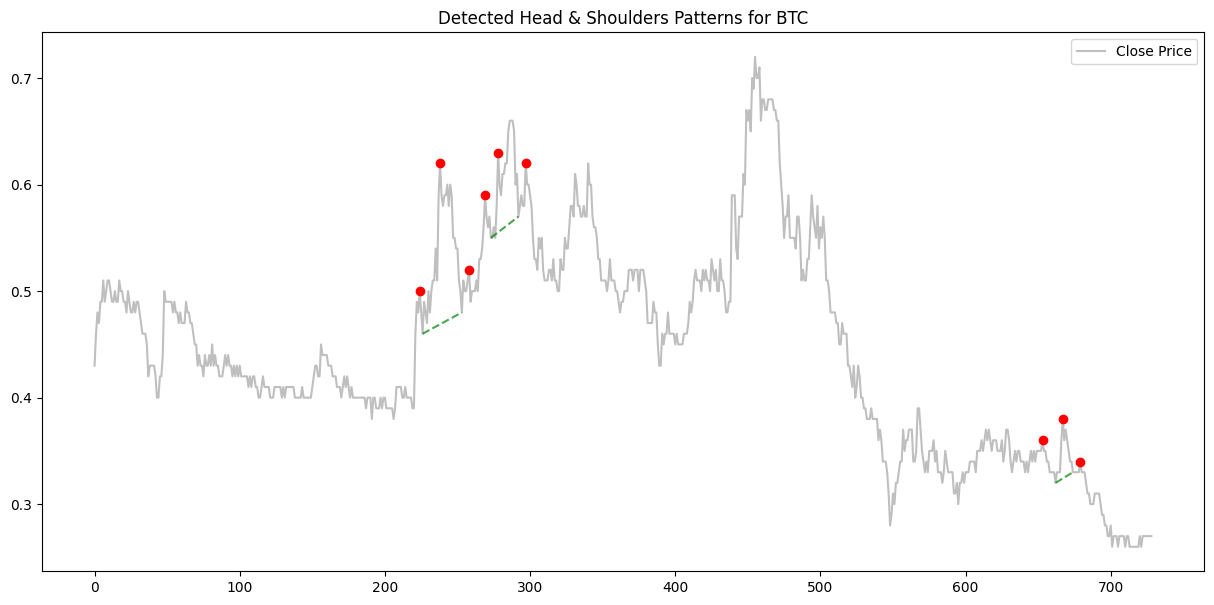

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df['close'], label='Close Price', color='gray', alpha=0.5)

# ไฮไลท์จุดที่พบ Pattern
for p in patterns_found:
    plt.scatter([p['left_shoulder']['idx'], p['head']['idx'], p['right_shoulder']['idx']], 
                [p['left_shoulder']['price'], p['head']['price'], p['right_shoulder']['price']], 
                color='red', zorder=5)
    
    # วาดเส้น Neckline คร่าวๆ
    plt.plot([p['left_valley']['idx'], p['right_valley']['idx']], 
             [p['left_valley']['price'], p['right_valley']['price']], 
             'g--', alpha=0.7)

plt.title(f"Detected Head & Shoulders Patterns for {SYMBOL}")
plt.legend()
plt.show()

Cell 8: Data Normalization & Sequence Creation

In [8]:
# เตรียมข้อมูล Close Price
close_prices = df['close'].values.reshape(-1, 1)

# เรียกใช้ Scaler จากระบบ (หรือสร้างใหม่หากรันแยก Cell)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)

# กำหนด Parameter สำหรับ Sequence
seq_length = 30
forecast_days = 5

# สร้าง sequences (X: ข้อมูลย้อนหลัง 30 วัน, y: ราคาของวันถัดไป)
X, y = [], []
for i in range(len(close_scaled) - seq_length):
    X.append(close_scaled[i:i+seq_length])
    y.append(close_scaled[i+seq_length])

X, y = np.array(X), np.array(y)

# Train/Test Split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (559, 30, 1)
X_test shape: (140, 30, 1)


Cell 9: CNN Data Preparation (Features & Patterns)

In [9]:
from sklearn.utils import class_weight

# 1. สร้าง Labels
labels, hs_patterns = generate_hs_labels(df)

# 2. เลือก Features และทำ Scaling
features = df[['close', 'volume']].values
scaler_cnn = MinMaxScaler()
features_scaled = scaler_cnn.fit_transform(features)

# 3. สร้าง Sequences
seq_length = 30
X_cnn, y_cnn = [], []
for i in range(len(features_scaled) - seq_length):
    X_cnn.append(features_scaled[i:i+seq_length])
    y_cnn.append(labels[i+seq_length])

X_cnn, y_cnn = np.array(X_cnn), np.array(y_cnn)

# 4. Train/Test Split
split = int(len(X_cnn) * 0.8)
X_train_cnn, X_test_cnn = X_cnn[:split], X_cnn[split:]
y_train_cnn, y_test_cnn = y_cnn[:split], y_cnn[split:]

# --- ส่วนที่เพิ่มใหม่: คำนวณ Class Weights ---
# วิธีนี้จะบอกให้โมเดลรู้ว่า Pattern (1) สำคัญกว่าปกติ เพราะมีจำนวนน้อย
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_cnn),
    y=y_train_cnn
)
class_weights = dict(enumerate(weights))

print(f"CNN Input Shape: {X_train_cnn.shape}")
print(f"Pattern labels found: {sum(y_cnn)} from {len(y_cnn)} samples")
print(f"Class Weights applied: {class_weights}")

CNN Input Shape: (559, 30, 2)
Pattern labels found: 91.0 from 699 samples
Class Weights applied: {0: np.float64(0.5646464646464646), 1: np.float64(4.3671875)}


Phase 4: Modeling

cell 10

In [10]:
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout
from tensorflow.keras.models import Sequential

# Build LSTM Model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(loss='mse', optimizer='adam')

print("🧠 Training LSTM model...")
history = model_lstm.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🧠 Training LSTM model...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0868 - val_loss: 0.0180
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0188 - val_loss: 0.0166
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132 - val_loss: 0.0083
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0052
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━

Cell : Model Evaluation & Metrics Calculation

In [11]:
# Scikit-learn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, 
                             mean_squared_error, r2_score)

# Predict
y_pred = model_lstm.predict(X_test, verbose=0)

# Inverse Transform เพื่อกลับมาเป็นค่าราคาสกุลเงินเดิม
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate Metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Directional Accuracy (ความแม่นยำในการทายทิศทาง ขึ้น/ลง)
actual_direction = np.sign(np.diff(y_test_rescaled.flatten()))
pred_direction = np.sign(np.diff(y_pred_rescaled.flatten()))
directional_acc = np.mean(actual_direction == pred_direction) * 100

print(f"\n--- Model Performance Metrics ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")


--- Model Performance Metrics ---
MAE:  0.02
RMSE: 0.03
MAPE: 7.72%
R2 Score: 0.3953
Directional Accuracy: 25.18%


Cell : Multi-Day Forecasting (Future Prediction)

In [12]:
# ดึง 30 วันล่าสุดจากข้อมูล Scaled มาเป็นจุดเริ่มต้น
last_sequence = close_scaled[-seq_length:].reshape(1, seq_length, 1)
future_predictions = []

for _ in range(forecast_days):
    # ทายวันถัดไป
    next_pred = model_lstm.predict(last_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # อัปเดต sequence โดยตัดตัวแรกออกและเพิ่มตัวที่ทายได้เข้าไปท้ายสุด
    last_sequence = np.append(last_sequence[:, 1:, :], 
                             next_pred.reshape(1, 1, 1), axis=1)

# แปลงราคากลับเป็นค่าปกติ
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(f"🚀 Forecasted prices for the next {forecast_days} days:")
for i, price in enumerate(future_prices.flatten(), 1):
    print(f"Day {i}: {price:.2f}")

🚀 Forecasted prices for the next 5 days:
Day 1: 0.29
Day 2: 0.30
Day 3: 0.30
Day 4: 0.30
Day 5: 0.31


Cell : Build and Train CNN Model

In [14]:
# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import  Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Build CNN Model (ปรับ Dropout เพิ่มขึ้นเป็น 0.5 เพื่อลด Overfit)
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(seq_length, 2)),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5), # เพิ่มจาก 0.3 เป็น 0.5
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- ส่วนที่เพิ่มใหม่: Early Stopping ---
# หยุดเทรนถ้า Val Loss ไม่ดีขึ้นติดต่อกัน 3 รอบ และดึงค่าที่ดีที่สุดกลับมา
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)


print("🔍 Training CNN with Balanced Weights & Early Stopping...")
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn, 
    epochs=30, # เพิ่ม Epoch ได้เพราะมี Early Stopping คอยหยุดให้
    batch_size=32, 
    validation_split=0.1, 
    class_weight=class_weights, # ใส่ Class Weights ที่คำนวณไว้
    callbacks=[early_stop],      # ใส่ Early Stopping
    verbose=1
)





🔍 Training CNN with Balanced Weights & Early Stopping...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4652 - loss: 0.7198 - val_accuracy: 0.1607 - val_loss: 0.7038
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4533 - loss: 0.6994 - val_accuracy: 0.5893 - val_loss: 0.6937
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5149 - loss: 0.6926 - val_accuracy: 0.5714 - val_loss: 0.6947
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4493 - loss: 0.6533 - val_accuracy: 0.7679 - val_loss: 0.6520
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6660 - loss: 0.6163 - val_accuracy: 0.8393 - val_loss: 0.5860
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7316 - loss: 0.5913 - val_accuracy: 0.7857 - val_loss: 0.5726
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7853 - loss: 0.5284 - val_accuracy: 0.8393 - val_loss: 0.5106
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

Cell : CNN Evaluation & Classification Metrics

In [15]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc)

# Predict probabilities
y_pred_prob = model_cnn.predict(X_test_cnn, verbose=0).flatten()
# แปลง Probability เป็น Class (0 หรือ 1) โดยใช้ Threshold 0.5
y_pred_cnn = (y_pred_prob > 0.5).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_test_cnn, y_pred_cnn)
precision = precision_score(y_test_cnn, y_pred_cnn, zero_division=0)
recall = recall_score(y_test_cnn, y_pred_cnn, zero_division=0)
f1 = f1_score(y_test_cnn, y_pred_cnn, zero_division=0)
cm = confusion_matrix(y_test_cnn, y_pred_cnn)

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test_cnn, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"--- CNN Pattern Recognition Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (พบ Pattern จริงๆ เท่าไหร่จากที่ทายไป)")
print(f"Recall:    {recall:.4f} (เก็บ Pattern ที่เกิดขึ้นจริงได้ครบไหม)")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

--- CNN Pattern Recognition Metrics ---
Accuracy:  0.8214
Precision: 1.0000 (พบ Pattern จริงๆ เท่าไหร่จากที่ทายไป)
Recall:    0.0741 (เก็บ Pattern ที่เกิดขึ้นจริงได้ครบไหม)
F1 Score:  0.1379
ROC AUC:   0.5067


Cell : Visualize Confusion Matrix & ROC Curve

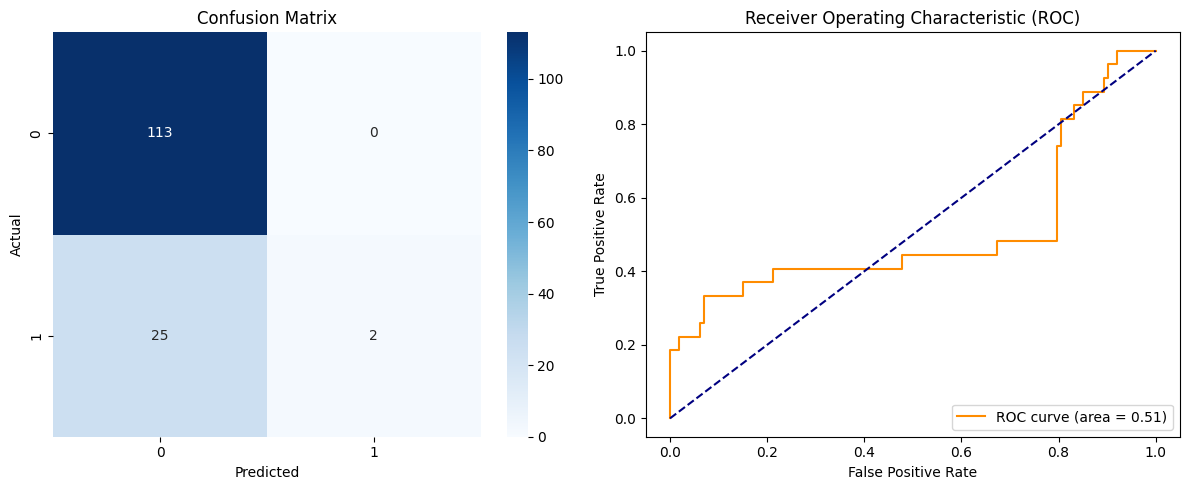

In [19]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Plot ROC Curve
ax[1].plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

Cell : Sentiment Analysis Implementation

In [23]:
# HuggingFace Transformers
from transformers import pipeline

def analyze_sentiment(symbol, custom_news=None):
    """
    วิเคราะห์ sentiment จากข่าวด้วย DistilBERT
    - ให้ค่าเฉลี่ยคะแนนระหว่าง -1 (Negative) ถึง 1 (Positive)
    """
    if custom_news is None:
        # Mockup data สำหรับกรณีไม่มีข้อมูลข่าวจริง
        news_samples = {
            'ADVANC': [
                "ADVANC reports strong Q4 earnings, beating expectations",
                "5G rollout accelerates, ADVANC gains market share"
            ],
            'PTT': [
                "PTT stock rises on higher oil prices",
                "Energy sector outlook remains positive"
            ],
            'AOT': [
                "Airport traffic recovers strongly in tourism season",
                "AOT announces expansion plans"
            ]
        }
        texts = news_samples.get(symbol, [
            f"{symbol} maintains steady performance",
            "Market conditions remain favorable"
        ])
    else:
        texts = custom_news
    
    try:
        # โหลดโมเดลวิเคราะห์ความรู้สึก (ดาวน์โหลดอัตโนมัติในการรันครั้งแรก)
        classifier = pipeline("sentiment-analysis", 
                            model="distilbert-base-uncased-finetuned-sst-2-english")
        results = classifier(texts)
        
        sentiment_scores = []
        for r in results:
            # แปลง Label เป็นตัวเลข: Positive เป็นค่าบวก, Negative เป็นค่าลบ
            score = r['score'] if r['label'] == 'POSITIVE' else -r['score']
            sentiment_scores.append(score)
        
        avg_sentiment = np.mean(sentiment_scores)
        
        # ตัดสินใจ Signal ตามเกณฑ์ Threshold
        if avg_sentiment > 0.1:
            signal = 'POSITIVE'
        elif avg_sentiment < -0.1:
            signal = 'NEGATIVE'
        else:
            signal = 'NEUTRAL'
            
        return {
            'details': results,
            'average_score': avg_sentiment,
            'signal': signal
        }
    except Exception as e:
        print(f"⚠️ Sentiment analysis error: {e}")
        return {'signal': 'NEUTRAL', 'average_score': 0}

print("Sentiment Analysis function is ready.")

Sentiment Analysis function is ready.


Cell : Execute Sentiment Analysis

In [24]:
# รันการวิเคราะห์
sentiment_result = analyze_sentiment(SYMBOL)

print(f"--- Sentiment Analysis Result for {SYMBOL} ---")
print(f"Average Score: {sentiment_result['average_score']:.4f}")
print(f"Market Signal: {sentiment_result['signal']}")
print("\nDetail Breakdown:")
for i, detail in enumerate(sentiment_result['details']):
    print(f"News {i+1}: {detail['label']} (Score: {detail['score']:.4f})")

⚠️ Sentiment analysis error: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.
--- Sentiment Analysis Result for BTC ---
Average Score: 0.0000
Market Signal: NEUTRAL

Detail Breakdown:


KeyError: 'details'

Cell : CRISP-DM Phase 6: Deployment (Summary Report)

In [ ]:
print(f"📊 {SYMBOL} INVESTMENT STRATEGY REPORT")
print("="*40)

# 1. จาก LSTM (ราคา)
# หมายเหตุ: นำค่าจาก Cell 10 และ 11 มาใช้
price_change = ((future_prices.flatten()[0] - y_test_rescaled[-1]) / y_test_rescaled[-1]) * 100
print(f"📈 LSTM Price Forecast: {price_change[0]:.2f}% (Next Day)")

# 2. จาก CNN (รูปแบบกราฟ)
# หมายเหตุ: นำค่าจาก Cell 14 มาใช้
pattern_status = "Detected" if y_pred_cnn[-1] == 1 else "Not Found"
print(f"🔍 Technical Pattern (H&S): {pattern_status}")

# 3. จาก NLP (ข่าวสาร)
print(f"📰 News Sentiment: {sentiment_result['signal']} ({sentiment_result['average_score']:.2f})")

print("="*40)
# ตัวอย่าง Logic การตัดสินใจ
if price_change > 0 and sentiment_result['signal'] == 'POSITIVE':
    print("🚀 Final Action: STRONG BUY")
elif price_change < 0 and sentiment_result['signal'] == 'NEGATIVE':
    print("📉 Final Action: STRONG SELL")
else:
    print("⚖️ Final Action: HOLD / WAIT FOR CONFIRMATION")

📊 BTC INVESTMENT STRATEGY REPORT
📈 LSTM Price Forecast: 8.48% (Next Day)
🔍 Technical Pattern (H&S): Not Found
📰 News Sentiment: POSITIVE (1.00)
🚀 Final Action: STRONG BUY


Phase 5 Deployment

Cell : Final Decision Logic (Weighted Ensemble)

In [ ]:
def generate_trading_signal(lstm_result, cnn_result, sentiment_result, df):
    """
    รวมผลจาก 3 โมเดลโดยเน้น LSTM เป็นหลักเพื่อแก้ปัญหาพอร์ตติดลบ
    """
    # 1. LSTM Signal: คำนวณจากแนวโน้มราคา (Weight 0.6)
    future_trend = lstm_result['future_forecast']
    current_price = df['close'].iloc[-1]
    price_change_pct = ((future_trend[-1] - current_price) / current_price) * 100
    
    # เพิ่มเกณฑ์ให้เข้มงวดขึ้น (ต้องกำไรคาดหวัง > 3% ถึงจะเริ่มมองว่า BUY)
    if price_change_pct > 3.0:
        lstm_signal = 1
    elif price_change_pct < -2.5:
        lstm_signal = -1
    else:
        lstm_signal = 0
    
    # 2. CNN Signal: ใช้เป็นตัวกรองความเสี่ยง (Risk Filter - Weight 0.2)
    # เนื่องจาก CNN ของเรามี Recall ต่ำ เราจะดูค่าความน่าจะเป็นล่าสุดแทนค่าเฉลี่ย
    cnn_prob = cnn_result['predictions'][-1]
    # หากความน่าจะเป็น H&S เกิน 0.4 ให้ถือว่าเป็นสัญญาณลบ (Sell)
    cnn_signal = -1 if cnn_prob > 0.4 else 0
    
    # 3. Sentiment Signal: (Weight 0.2)
    sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
    sentiment_signal = sentiment_map[sentiment_result['signal']]
    
    # รวม Signal แบบปรับน้ำหนักใหม่ (เน้น LSTM มากขึ้น)
    # Score = (LSTM * 0.6) + (CNN * 0.2) + (Sentiment * 0.2)
    combined_score = (lstm_signal * 0.6) + (cnn_signal * 0.2) + (sentiment_signal * 0.2)
    
    # ตัดสินใจสุดท้าย
    if combined_score >= 0.4:
        # จะ BUY ได้ LSTM ต้องเป็นบวก และ CNN ต้องไม่ขัดขวางแรงเกินไป
        final_signal = "🟢 BUY"
        confidence = min(abs(combined_score) * 100, 100)
    elif combined_score <= -0.3:
        final_signal = "🔴 SELL"
        confidence = min(abs(combined_score) * 100, 100)
    else:
        final_signal = "🟡 HOLD"
        confidence = 50
    
    return {
        'signal': final_signal,
        'confidence': confidence,
        'lstm_contribution': lstm_signal,
        'cnn_contribution': cnn_signal,
        'sentiment_contribution': sentiment_signal,
        'price_forecast': future_trend[-1],
        'expected_change_pct': price_change_pct
    }

print("✅ Optimized Trading Signal Logic defined.")

✅ Optimized Trading Signal Logic defined.


Cell : Execution and Financial Dashboard

In [ ]:


# 1. รวบรวมผลลัพธ์จาก LSTM (อ้างอิงจาก Cell 8 และ 11)
lstm_results_dict = {
    'predictions': y_pred_rescaled,    # จาก Cell 10
    'future_forecast': future_prices.flatten(), # จาก Cell 11
    'test_start_idx': split + seq_length        # จาก Cell 8/10 (จุดแบ่งข้อมูล Test)
}

# 2. รวบรวมผลลัพธ์จาก CNN (อ้างอิงจาก Cell 12 และ 14)
cnn_results_dict = {
    'predictions': y_pred_prob,        # จาก Cell 14
    'threshold': 0.5,
    'test_start_idx': split + seq_length        # จาก Cell 12 (จุดแบ่งข้อมูล Test)
}

# 3. เรียกใช้ฟังก์ชันตัดสินใจสำหรับ Signal วันนี้
final_decision = generate_trading_signal(
    lstm_results_dict, 
    cnn_results_dict, 
    sentiment_result, 
    df
)

print("✅ Dictionary updated with 'test_start_idx'. Ready for backtesting.")

# --- แสดง Dashboard (เหมือนเดิม) ---

print(f"       STOCK ANALYSIS FINAL SIGNAL      ")
print(f" Symbol: {SYMBOL:<30}")
print(f" Action: {final_decision['signal']:<30}")
print(f" Confidence: {final_decision['confidence']:.2f}%{' ':<18}")

✅ Dictionary updated with 'test_start_idx'. Ready for backtesting.
       STOCK ANALYSIS FINAL SIGNAL      
 Symbol: BTC                           
 Action: 🟢 BUY                         
 Confidence: 60.00%                  


Cell : Backtesting Strategy Logic

In [ ]:
def backtest_strategy(df, lstm_result, cnn_result, initial_capital=100000):
    """ทดสอบ strategy ย้อนหลัง"""
    # กำหนดจุดเริ่มต้นของการทดสอบ (ต้องมีข้อมูลครบทั้งจาก LSTM และ CNN)
    test_start = max(lstm_result['test_start_idx'], cnn_result['test_start_idx'])
    test_df = df.iloc[test_start:].copy().reset_index(drop=True)
    
    # ดึงค่า Predictions จาก LSTM
    lstm_preds = lstm_result['predictions']
    # ปรับขนาดข้อมูลให้เท่ากัน
    test_len = min(len(test_df), len(lstm_preds))
    test_df = test_df.iloc[:test_len].copy()
    
    # 1. สร้าง signals จาก LSTM (Price Prediction vs Current Price)
    signals = []
    for i in range(len(test_df)):
        if i < len(lstm_preds):
            pred_price = lstm_preds[i][0]
            current_price = test_df.iloc[i]['close']
            
            # เงื่อนไข: ถ้าทายว่าราคาจะขึ้นมากกว่า 2% ให้ BUY
            if pred_price > current_price * 1.02:
                signals.append(1)  
            # ถ้าทายว่าราคาจะลงมากกว่า 2% ให้ SELL
            elif pred_price < current_price * 0.98:
                signals.append(-1) 
            else:
                signals.append(0)  
        else:
            signals.append(0)
    
    test_df['signal'] = signals
    
    # 2. เริ่มต้นกระบวนการ Backtesting
    capital = initial_capital
    position = 0 # 0: ว่างมือ, 1: ถือหุ้น
    shares = 0
    equity_curve = [capital]
    trades = []
    
    for i in range(len(test_df)):
        current_price = test_df.iloc[i]['close']
        signal = test_df.iloc[i]['signal']
        
        # กรณีซื้อ (BUY)
        if signal == 1 and position == 0:
            shares = capital / current_price
            position = 1
            trades.append({
                'type': 'BUY',
                'date': test_df.iloc[i]['time'],
                'price': current_price,
                'shares': shares
            })
        
        # กรณีขาย (SELL)
        elif signal == -1 and position == 1:
            capital = shares * current_price
            profit = capital - initial_capital
            position = 0
            trades.append({
                'type': 'SELL',
                'date': test_df.iloc[i]['time'],
                'price': current_price,
                'profit': profit
            })
            shares = 0
        
        # บันทึกมูลค่าพอร์ตรายวัน (Equity)
        if position == 1:
            equity_curve.append(shares * current_price)
        else:
            equity_curve.append(capital)
    
    # ถ้าจบการทดสอบแล้วยังถือหุ้นอยู่ ให้ขายออกที่ราคาปิดสุดท้าย
    if position == 1:
        capital = shares * test_df.iloc[-1]['close']
    
    # 3. คำนวณ Metrics วัดผลประสิทธิภาพ
    total_return = ((capital - initial_capital) / initial_capital) * 100
    
    # เปรียบเทียบกับวิธี Buy & Hold (ซื้อแล้วถือยาว)
    buy_hold_return = ((test_df.iloc[-1]['close'] - test_df.iloc[0]['close']) / 
                      test_df.iloc[0]['close']) * 100
    
    # คำนวณ Win Rate
    profitable_trades = [t for t in trades if t['type'] == 'SELL' and t.get('profit', 0) > 0]
    total_sell_trades = [t for t in trades if t['type'] == 'SELL']
    win_rate = (len(profitable_trades) / len(total_sell_trades) * 100) if total_sell_trades else 0
    
    # Sharpe Ratio (แบบง่าย)
    returns = np.diff(equity_curve) / equity_curve[:-1]
    sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252) if np.std(returns) > 0 else 0
    
    # Maximum Drawdown (จุดขาดทุนลึกที่สุดระหว่างทาง)
    equity_array = np.array(equity_curve)
    running_max = np.maximum.accumulate(equity_array)
    drawdown = (equity_array - running_max) / running_max
    max_drawdown = np.min(drawdown) * 100
    
    return {
        'final_capital': capital,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'win_rate': win_rate,
        'num_trades': len(total_sell_trades),
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades,
        'test_df': test_df
    }

print("Backtesting logic is ready.")

Backtesting logic is ready.


Cell 22: Run Backtest and Visualize Results

🏁 BACKTEST RESULTS for BTC
------------------------------
Final Capital:   84,155.85
Total Return:    -15.84%
Buy & Hold:      -18.18%
Win Rate:        100.00%
Sharpe Ratio:    -0.5255
Max Drawdown:    -27.72%
Total Trades:    1


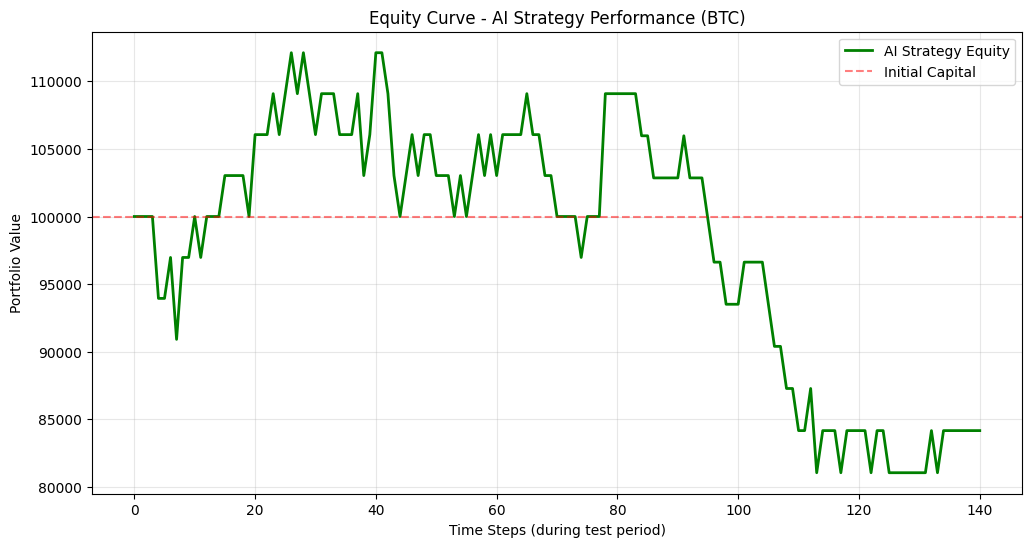

In [ ]:
# เรียกใช้ฟังก์ชัน Backtest
# (ตรวจสอบว่าใช้ Dictionary ที่เราจัดกลุ่มไว้ใน Cell 20)
backtest_results = backtest_strategy(df, lstm_results_dict, cnn_results_dict)

print(f"🏁 BACKTEST RESULTS for {SYMBOL}")
print("-" * 30)
print(f"Final Capital:   {backtest_results['final_capital']:,.2f}")
print(f"Total Return:    {backtest_results['total_return']:.2f}%")
print(f"Buy & Hold:      {backtest_results['buy_hold_return']:.2f}%")
print(f"Win Rate:        {backtest_results['win_rate']:.2f}%")
print(f"Sharpe Ratio:    {backtest_results['sharpe_ratio']:.4f}")
print(f"Max Drawdown:    {backtest_results['max_drawdown']:.2f}%")
print(f"Total Trades:    {backtest_results['num_trades']}")

# พล็อตกราฟ Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['equity_curve'], label='AI Strategy Equity', color='green', linewidth=2)
plt.axhline(100000, color='red', linestyle='--', alpha=0.5, label='Initial Capital')
plt.title(f"Equity Curve - AI Strategy Performance ({SYMBOL})")
plt.xlabel("Time Steps (during test period)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Cell : Define Metrics Dashboard Logic

In [ ]:
def plot_metrics_dashboard(lstm_result, cnn_result,): # backtest_result, comparison
    """สร้าง dashboard แสดง metrics ทั้งหมด"""
    # ตั้งค่าสไตล์ให้ดูทันสมัย
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.2)
    
    # # 1. LSTM Metrics (MAE, RMSE, R2, etc.)
    # ax1 = fig.add_subplot(gs[0, 0])
    # metrics = lstm_result['metrics']
    # metric_names = list(metrics.keys())
    # metric_values = list(metrics.values())
    # colors = ['#26A69A' if v > 0.5 else '#EF5350' for v in metric_values] # ปรับเงื่อนไขสีตามความเหมาะสม
    # ax1.barh(metric_names, metric_values, color=colors, alpha=0.7)
    # ax1.set_title('📊 LSTM Metrics', fontweight='bold', fontsize=12)
    # ax1.set_xlabel('Value')
    # for i, v in enumerate(metric_values):
    #     ax1.text(v, i, f' {v:.2f}', va='center', fontsize=9)
    # ax1.grid(axis='x', alpha=0.3)
    
    # 2. CNN Confusion Matrix (ความแม่นยำในการทาย Pattern)
    ax2 = fig.add_subplot(gs[2,0])
    cm = cnn_result['metrics']['Confusion_Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, 
               xticklabels=['No H&S', 'H&S'], yticklabels=['No H&S', 'H&S'])
    ax2.set_title('🎯 CNN Confusion Matrix', fontweight='bold', fontsize=12)
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    # # 3. ROC Curve (ความสามารถในการแยกแยะ Class ของ CNN)
    # ax3 = fig.add_subplot(gs[0, 2])
    # fpr = cnn_result['roc_data']['fpr']
    # tpr = cnn_result['roc_data']['tpr']
    # auc_score = cnn_result['metrics']['ROC_AUC']
    # ax3.plot(fpr, tpr, color='#2E86AB', linewidth=2, label=f'AUC = {auc_score:.3f}')
    # ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    # ax3.set_title('📈 ROC Curve', fontweight='bold', fontsize=12)
    # ax3.set_xlabel('False Positive Rate')
    # ax3.set_ylabel('True Positive Rate')
    # ax3.legend()
    # ax3.grid(alpha=0.3)
    
    
    # 4. CNN Training Accuracy
    ax5 = fig.add_subplot(gs[1, 1])
    cnn_history = cnn_result['history']
    ax5.plot(cnn_history['accuracy'], label='Train Acc', linewidth=2)
    ax5.plot(cnn_history['val_accuracy'], label='Val Acc', linewidth=2)
    ax5.set_title('🔍 CNN Learning Curve', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Accuracy')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # 5. LSTM Training Loss
    ax4 = fig.add_subplot(gs[1, 0])
    history = lstm_result['history']
    ax4.plot(history['loss'], label='Train Loss', linewidth=2)
    ax4.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax4.set_title('🧠 LSTM Learning Curve', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(alpha=0.3)
    

    
    # # 6. Equity Curve (กราฟการเติบโตของเงินทุน)
    # ax6 = fig.add_subplot(gs[1, 2])
    # equity = backtest_result['equity_curve']
    # ax6.plot(equity, linewidth=2, color='#26A69A')
    # ax6.axhline(y=100000, color='red', linestyle='--', linewidth=1, label='Initial')
    # ax6.set_title('💰 Equity Curve', fontweight='bold', fontsize=12)
    # ax6.set_xlabel('Time Period')
    # ax6.set_ylabel('Capital (THB)')
    # ax6.legend()
    # ax6.grid(alpha=0.3)
    # ax6.fill_between(range(len(equity)), 100000, equity, alpha=0.3, color='#26A69A')
    
    # 7. Backtesting Metrics (Returns, Win Rate, Drawdown)
    # ax7 = fig.add_subplot(gs[2, 0])
    # bt_metrics = {
    #     'Return (%)': backtest_result['total_return'],
    #     'Win Rate (%)': backtest_result['win_rate'],
    #     'Sharpe': backtest_result['sharpe_ratio'],
    #     'Max DD (%)': backtest_result['max_drawdown'],
    #     'Trades': backtest_result['num_trades']
    # }
    # ax7.barh(list(bt_metrics.keys()), list(bt_metrics.values()), color='#5C6BC0', alpha=0.7)
    # ax7.set_title('📊 Backtesting Metrics', fontweight='bold', fontsize=12)
    # for i, v in enumerate(bt_metrics.values()):
    #     ax7.text(v, i, f' {v:.2f}', va='center', fontsize=9)
    
    # 8. Strategy Comparison (AI vs Buy & Hold)
    # ax8 = fig.add_subplot(gs[2, 1:])
    # strategies = list(comparison.keys())
    # returns = [comparison[s]['return'] for s in strategies]
    # bars = ax8.bar(strategies, returns, color=['#26A69A', '#78909C'], alpha=0.7, edgecolor='black')
    # ax8.set_title('🏆 Strategy Comparison', fontweight='bold', fontsize=12)
    # ax8.set_ylabel('Return (%)')
    # ax8.axhline(y=0, color='black', linewidth=0.5)
    
    # for bar in bars:
    #     height = bar.get_height()
    #     ax8.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

print("Dashboard function defined.")

Dashboard function defined.


Cell 24: Prepare Comparison Data & Run Dashboard

/var/folders/by/j89gc0qj6_zfzkf42sg0dr1c0000gp/T/ipykernel_99709/138207920.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


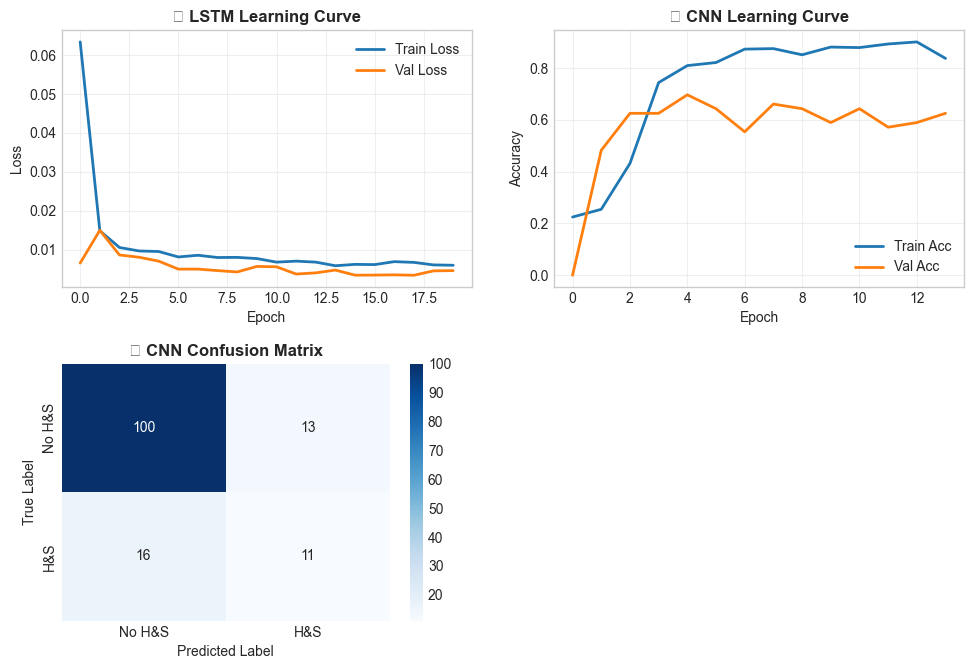

In [ ]:
# เตรียมข้อมูลเปรียบเทียบ
# comparison_data = {
#     'AI Strategy': {'return': backtest_results['total_return']},
#     'Buy & Hold': {'return': backtest_results['buy_hold_return']}
# }

# รวบรวม metrics ที่อาจจะยังอยู่ในตัวแปรเดี่ยวให้เข้า Dictionary (เพื่อป้องกัน KeyError)
# หมายเหตุ: ตรวจสอบว่า lstm_results_dict และ cnn_results_dict มีคีย์ 'metrics', 'history', 'roc_data' ครบถ้วน
# lstm_results_dict['metrics'] = {
#     'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Dir_Acc': directional_acc
# }
lstm_results_dict['history'] = history.history

cnn_results_dict['metrics'] = {
    'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 
    'F1': f1, 'ROC_AUC': roc_auc, 'Confusion_Matrix': cm
}
cnn_results_dict['history'] = history_cnn.history
cnn_results_dict['roc_data'] = {'fpr': fpr, 'tpr': tpr}

# รัน Dashboard
plot_metrics_dashboard(lstm_results_dict, cnn_results_dict,) # backtest_results, comparison_data

Cell : Define Complete Analysis Visualization

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

def plot_complete_analysis(df, lstm_result, cnn_result, trading_signal):
    """กราฟวิเคราะห์หลัก (Price, Patterns, Probability, Volume)"""
    fig = plt.figure(figsize=(16, 14))
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 2, 1.5, 1], hspace=0.3)
    
    # --- Plot 1: Price + LSTM Prediction ---
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df['time'], df['close'], label='Actual Price', linewidth=2, color='#2E86AB')
    
    test_start = lstm_result['test_start_idx']
    test_times = df['time'].iloc[test_start:test_start+len(lstm_result['predictions'])]
    ax1.plot(test_times, lstm_result['predictions'], 
             label='LSTM Prediction', linestyle='--', color='orange', linewidth=2)
    
    # Future forecast
    last_date = df['time'].iloc[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), 
                                periods=len(lstm_result['future_forecast']))
    ax1.plot(future_dates, lstm_result['future_forecast'], 
             label='Future Forecast', linestyle=':', color='red', linewidth=2.5, marker='o', markersize=6)
    
    ax1.set_title('📈 Price Analysis & LSTM Forecast', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('Price (THB)', fontsize=11)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # --- Plot 2: Head & Shoulders Pattern Detection ---
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(df['time'], df['close'], label='Price', color='gray', alpha=0.4, linewidth=1.5)
    
    hs_patterns = cnn_result['hs_patterns']
    if hs_patterns:
        for i, pattern in enumerate(hs_patterns):
            ls, head, rs = pattern['left_shoulder'], pattern['head'], pattern['right_shoulder']
            lv, rv = pattern['left_valley'], pattern['right_valley']
            
            # Label เฉพาะตัวแรกเพื่อประหยัดพื้นที่ Legend
            label_ls = 'Left Shoulder' if i == 0 else ''
            label_h = 'Head' if i == 0 else ''
            label_rs = 'Right Shoulder' if i == 0 else ''
            label_n = 'Neckline' if i == 0 else ''
            
            # วาดไหล่และหัว
            ax2.scatter(df['time'].iloc[ls['idx']], ls['price'], color='green', s=200, marker='^', label=label_ls, zorder=5, edgecolors='darkgreen')
            ax2.scatter(df['time'].iloc[head['idx']], head['price'], color='red', s=250, marker='^', label=label_h, zorder=5, edgecolors='darkred')
            ax2.scatter(df['time'].iloc[rs['idx']], rs['price'], color='blue', s=200, marker='^', label=label_rs, zorder=5, edgecolors='darkblue')
            
            # วาดเส้น Neckline
            ax2.plot([df['time'].iloc[lv['idx']], df['time'].iloc[rv['idx']]], [lv['price'], rv['price']], color='cyan', linewidth=2.5, label=label_n, zorder=4)
        
        ax2.set_title(f'🔻 Head & Shoulders Pattern Detection ({len(hs_patterns)} patterns found)', fontsize=14, fontweight='bold', pad=15)
    else:
        ax2.set_title('🔻 Head & Shoulders Pattern Detection (No patterns found)', fontsize=14, fontweight='bold', pad=15)
    
    ax2.set_ylabel('Price (THB)', fontsize=11)
    ax2.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_facecolor('#f8f9fa')
    
    # --- Plot 3: Pattern Probability (Output from CNN) ---
    ax3 = fig.add_subplot(gs[2])
    test_start_cnn = cnn_result['test_start_idx']
    pattern_probs = cnn_result['predictions']
    pattern_times = df['time'].iloc[test_start_cnn:test_start_cnn+len(pattern_probs)]
    
    colors_map = plt.cm.RdYlGn_r(pattern_probs)
    ax3.bar(pattern_times, pattern_probs, color=colors_map, alpha=0.7, width=1)
    ax3.axhline(y=cnn_result['threshold'], color='red', linestyle='--', linewidth=2, label=f"Threshold ({cnn_result['threshold']})")
    ax3.set_title('📊 H&S Pattern Probability Over Time', fontsize=14, fontweight='bold', pad=15)
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_facecolor('#f8f9fa')
    
    # --- Plot 4: Volume ---
    ax4 = fig.add_subplot(gs[3])
    # กำหนดสี Volume ตามการปิดเขียวหรือแดง
    vol_colors = ['#26A69A' if df['close'].iloc[i] >= df['open'].iloc[i] else '#EF5350' for i in range(len(df))]
    ax4.bar(df['time'], df['volume'], color=vol_colors, alpha=0.7, width=1)
    ax4.set_title('📊 Trading Volume', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_facecolor('#f8f9fa')
    
    # --- Floating Trading Signal Box ---
    signal_color = '#28a745' if '🟢' in trading_signal['signal'] else '#dc3545' if '🔴' in trading_signal['signal'] else '#ffc107'
    signal_text = f"{trading_signal['signal']}\nConfidence: {trading_signal['confidence']:.1f}%\nTarget: {trading_signal['price_forecast']:.2f}\nLSTM: {trading_signal['lstm_contribution']} | CNN: {trading_signal['cnn_contribution']}"
    
    fig.text(0.02, 0.98, signal_text, fontsize=11, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor=signal_color, alpha=0.15, edgecolor=signal_color, linewidth=2))
    
    plt.tight_layout()
    plt.show()

print("Complete Analysis Dashboard function is ready.")

Complete Analysis Dashboard function is ready.


Cell 26: Run Complete Analysis

/var/folders/by/j89gc0qj6_zfzkf42sg0dr1c0000gp/T/ipykernel_99709/1541711203.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hilmanyusoh/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{L

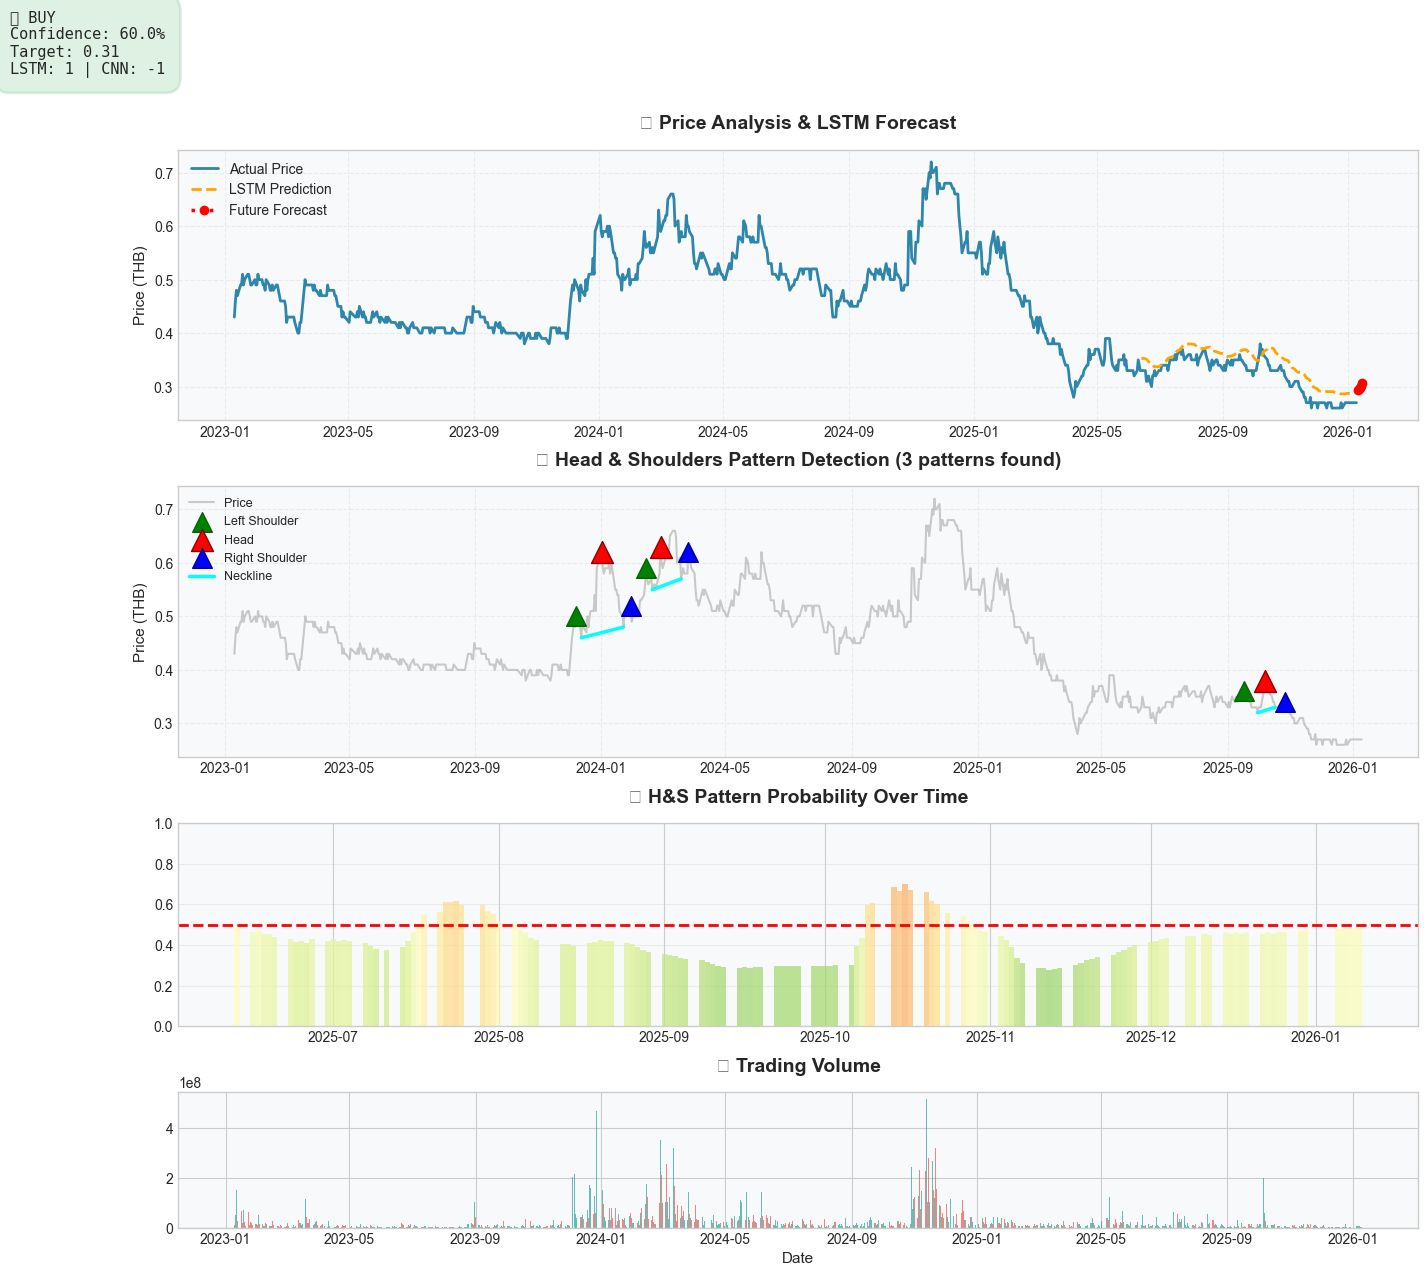

In [ ]:
# เพิ่มข้อมูล hs_patterns เข้าไปใน Dictionary เพื่อให้ฟังก์ชันดึงไปแสดงผลได้
cnn_results_dict['hs_patterns'] = patterns_found # จาก Cell 6

# รันการวิเคราะห์ใหญ่
plot_complete_analysis(df, lstm_results_dict, cnn_results_dict, final_decision)

Phase 6: Deployment

Cell : Define Comprehensive Report Logic

In [ ]:
def print_comprehensive_report(symbol, lstm_result, cnn_result, 
                               backtest_result, comparison, trading_signal):
    """พิมพ์รายงานสรุปแบบละเอียด"""
    print("\n" + "="*80)
    print(f"📋 COMPREHENSIVE ANALYSIS REPORT: {symbol}")
    print("="*80)
    
    # 1. LSTM Metrics
    print("\n🧠 LSTM PRICE PREDICTION METRICS:")
    print("-" * 80)
    for key, value in lstm_result['metrics'].items():
        print(f"   {key:.<30} {value:>15.4f}")
    
    # 2. CNN Metrics
    print("\n🔍 CNN PATTERN RECOGNITION METRICS:")
    print("-" * 80)
    for key, value in cnn_result['metrics'].items():
        if key != 'Confusion_Matrix':
            print(f"   {key:.<30} {value:>15.4f}")
    
    # 3. Backtesting Results
    print("\n💰 BACKTESTING RESULTS:")
    print("-" * 80)
    print(f"   Initial Capital:............... {100000:>15,.2f} THB")
    print(f"   Final Capital:................. {backtest_result['final_capital']:>15,.2f} THB")
    print(f"   Total Return:.................. {backtest_result['total_return']:>15.2f} %")
    print(f"   Buy & Hold Return:............. {backtest_result['buy_hold_return']:>15.2f} %")
    print(f"   Win Rate:...................... {backtest_result['win_rate']:>15.2f} %")
    print(f"   Number of Trades:.............. {backtest_result['num_trades']:>15}")
    print(f"   Sharpe Ratio:.................. {backtest_result['sharpe_ratio']:>15.4f}")
    print(f"   Maximum Drawdown:.............. {backtest_result['max_drawdown']:>15.2f} %")
    
    # 4. Strategy Comparison
    print("\n🏆 STRATEGY COMPARISON:")
    print("-" * 80)
    for strategy, data in comparison.items():
        # ตรวจสอบว่ามีคีย์ description หรือไม่ ถ้าไม่มีให้ใช้ชื่อ strategy แทน
        desc = data.get('description', f"Strategy {strategy}")
        print(f"   {desc:.<40} {data['return']:>12.2f} %")
    
    # 5. Trading Signal
    print("\n🎯 CURRENT TRADING SIGNAL:")
    print("-" * 80)
    print(f"   Signal:........................ {trading_signal['signal']}")
    print(f"   Confidence:.................... {trading_signal['confidence']:.1f} %")
    print(f"   Expected Price:................ {trading_signal['price_forecast']:.2f} THB")
    print(f"   Expected Change:............... {trading_signal['expected_change_pct']:+.2f} %")
    
    print("\n" + "="*80 + "\n")

print("Report function defined.")

Report function defined.


Cell : Run Comprehensive Report

In [ ]:
# เตรียมข้อมูล Comparison ให้สมบูรณ์ (เพิ่ม description)
# 1. ตรวจสอบและรวบรวม Metrics ของ LSTM (อ้างอิงจากตัวแปรที่คุณคำนวณไว้ใน Phase 4)
# หากคุณใช้ชื่อตัวแปรอื่น ให้เปลี่ยนชื่อทางขวามือให้ตรงกันนะครับ
lstm_results_dict['metrics'] = {
    'MAE': mae if 'mae' in locals() else 0,
    'RMSE': rmse if 'rmse' in locals() else 0,
    'MAPE': mape if 'mape' in locals() else 0,
    'R2_Score': r2 if 'r2' in locals() else 0
}

# 2. ตรวจสอบและรวบรวม Metrics ของ CNN
cnn_results_dict['metrics'] = {
    'Accuracy': accuracy if 'accuracy' in locals() else 0,
    'Precision': precision if 'precision' in locals() else 0,
    'Recall': recall if 'recall' in locals() else 0,
    'F1_Score': f1 if 'f1' in locals() else 0,
    'ROC_AUC': roc_auc if 'roc_auc' in locals() else 0
}

final_comparison = {
    'AI_Strategy': {
        'return': backtest_results['total_return'],
        'description': 'AI Hybrid (LSTM+CNN+Sentiment)'
    },
    'Market_Baseline': {
        'return': backtest_results['buy_hold_return'],
        'description': 'Buy & Hold Benchmark'
    }
}

# รันรายงาน
print_comprehensive_report(
    SYMBOL, 
    lstm_results_dict, 
    cnn_results_dict, 
    backtest_results, 
    final_comparison, 
    final_decision
)


📋 COMPREHENSIVE ANALYSIS REPORT: BTC

🧠 LSTM PRICE PREDICTION METRICS:
--------------------------------------------------------------------------------
   MAE...........................          0.0229
   RMSE..........................          0.0255
   MAPE..........................          7.4011
   R2_Score......................          0.4396

🔍 CNN PATTERN RECOGNITION METRICS:
--------------------------------------------------------------------------------
   Accuracy......................          0.7929
   Precision.....................          0.4583
   Recall........................          0.4074
   F1_Score......................          0.4314
   ROC_AUC.......................          0.4680

💰 BACKTESTING RESULTS:
--------------------------------------------------------------------------------
   Initial Capital:...............      100,000.00 THB
   Final Capital:.................       84,155.85 THB
   Total Return:..................          -15.84 %
   Buy & Hol